In [1]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [8]:
parser = Sbopen()
games_df = parser.match(competition_id=2,season_id=27)

match_ids = games_df['match_id'].to_list()
len(match_ids)

380

In [49]:
# finding danger passes for every team in the league

team_danger_passes = {}

for idx in match_ids:
    df = parser.event(idx)[0]

    teams = df['team_name'].unique()

    for team in teams:
        for period in [1,2]:
            pass_mask = (df.team_name==team)&(df.type_name=='Pass')&(df.outcome_name.isnull())&(df.period==period)&(df.sub_type_name.isnull())
            team_passes = df[pass_mask][['x','y','end_x','end_y','minute','second','player_name','team_name']]
    
    
            shot_mask = (df.type_name=='Shot')&(df.period==period)&(df.team_name==team)
            team_shots = df[shot_mask][['minute','second','team_name']]
            
            shot_times = team_shots['minute']*60+team_shots['second']
            shot_window = 15

            shot_start = shot_times - shot_window
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)

            pass_times = team_passes['minute']*60+team_passes['second']
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start<x)&(x<shot_times)).unique())

            danger_passes = team_passes[pass_to_shot]

            if not danger_passes.empty:
                if team not in team_danger_passes:
                    team_danger_passes[team] = [danger_passes]
                else:
                    team_danger_passes[team].append(danger_passes)

for team in team_danger_passes:
    team_danger_passes[team] = pd.concat(team_danger_passes[team],ignore_index=True)


In [28]:
league_danger_passes = pd.concat([df.assign(team=team) for team, df in team_danger_passes.items()],
                                ignore_index=True)

league_danger_passes = league_danger_passes.drop(columns='team')
league_danger_passes.head(20)

,x,y,end_x,end_y,minute,second,player_name,team_name
0,55.5,8.9,69.8,1.2,9,6,Christian Fuchs,Leicester City
1,69.8,1.4,100.6,9.3,9,8,Marc Albrighton,Leicester City
2,101.7,1.6,89.5,9.6,9,15,N''Golo Kanté,Leicester City
3,86.9,14.5,114.3,51.3,9,17,Marc Albrighton,Leicester City
4,71.5,53.2,108.9,32.4,33,49,Riyad Mahrez,Leicester City
5,70.6,45.3,75.8,35.0,37,38,N''Golo Kanté,Leicester City
6,82.6,29.5,106.4,23.9,37,40,Riyad Mahrez,Leicester City
7,14.4,15.6,21.2,21.9,49,57,Christian Fuchs,Leicester City
8,21.2,21.9,12.8,12.4,49,58,Danny Drinkwater,Leicester City
9,18.4,6.8,42.1,5.4,50,1,Christian Fuchs,Leicester City


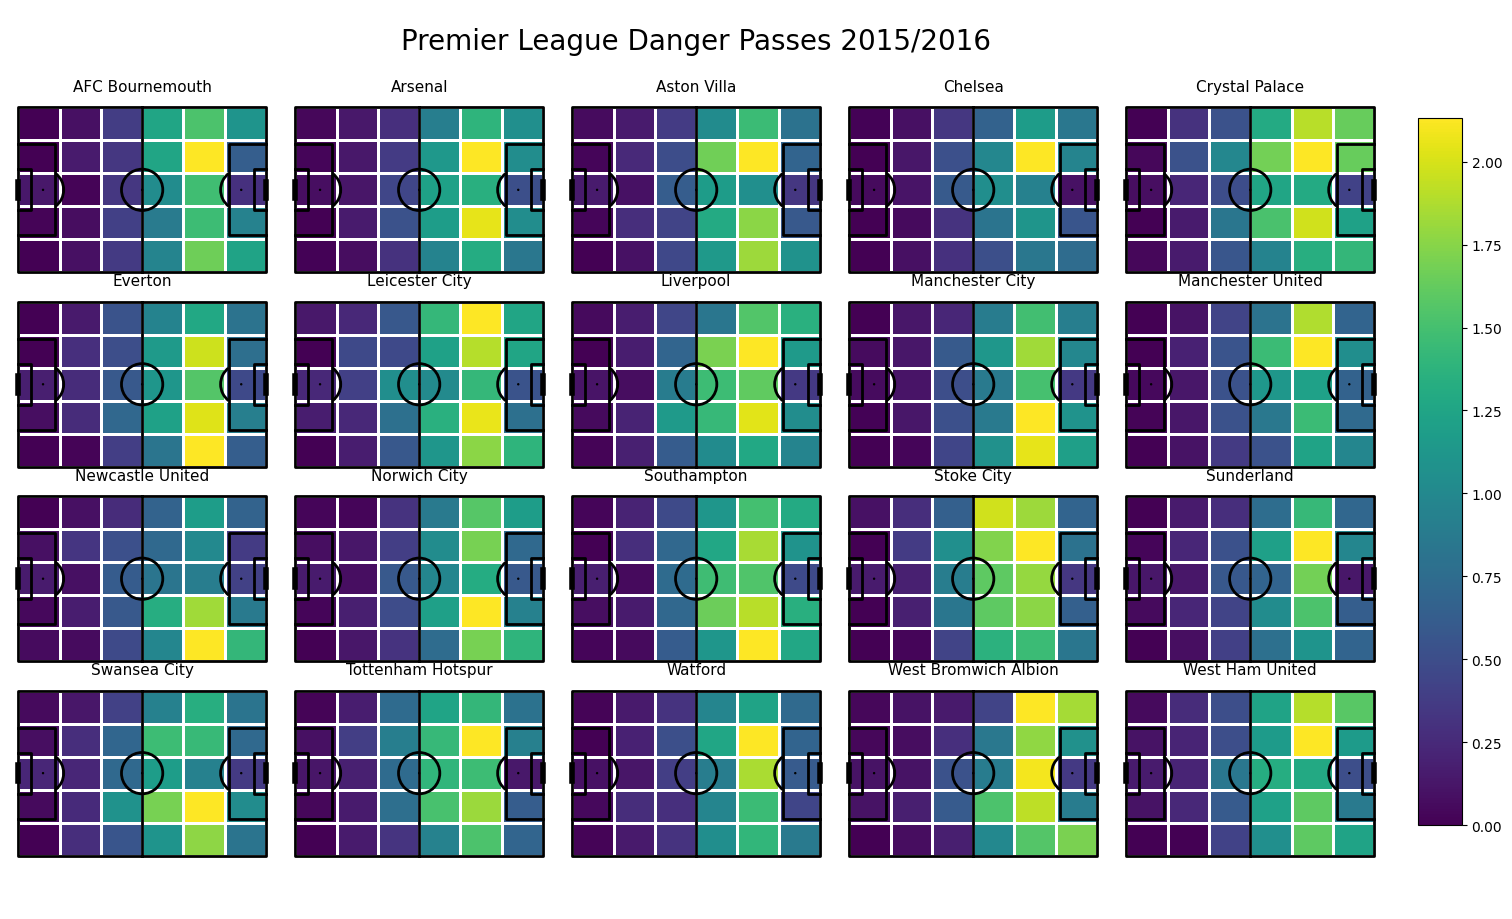

In [61]:
pitch = Pitch(line_color='black',line_zorder=2)
fig,axs = pitch.grid(ncols=5,nrows=4,grid_height=0.85,title_height=0.06,axis=False,
                    endnote_height=0.04,title_space=0.04,endnote_space=0.01)

teams = sorted(league_danger_passes.team_name.unique())

for team, ax in zip(teams, axs['pitch'].flat[:len(teams)]):
    ax.set_title(team,fontsize=11)
    team_df = league_danger_passes[league_danger_passes['team_name']==team]
    bin_statistic = pitch.bin_statistic(team_df.x,team_df.y,statistic='count',bins=(6,5),normalize=False)
    bin_statistic['statistic'] = bin_statistic['statistic']/38
    pcm = pitch.heatmap(bin_statistic,cmap='viridis',edgecolors='white',ax=ax)
    
ax_cbar = fig.add_axes((1,0.093,0.03,0.786))
cbar = plt.colorbar(pcm,cax=ax_cbar)
fig.suptitle('Premier League Danger Passes 2015/2016',fontsize=20)
plt.show()

# Kevin De Bruyne - 2015/2016 Attacking Play

In [69]:
team = 'Manchester City'
player = 'Kevin De Bruyne'

kdb_passes = pd.DataFrame()

city_ids = games_df[(games_df['home_team_name']==team)|(games_df['away_team_name']==team)]['match_id'].to_list()

for cid in city_ids:
    city = parser.event(cid)[0]

    kev_mask = (city.team_name==team)&(city.player_name==player)&(city.type_name=='Pass')&(city.outcome_name.isnull())&(city.sub_type_name.isnull())
    kev_passes = city[kev_mask][['match_id','x','y','end_x','end_y','player_name']]
    kdb_passes = pd.concat([kdb_passes,kev_passes],ignore_index=True)
    

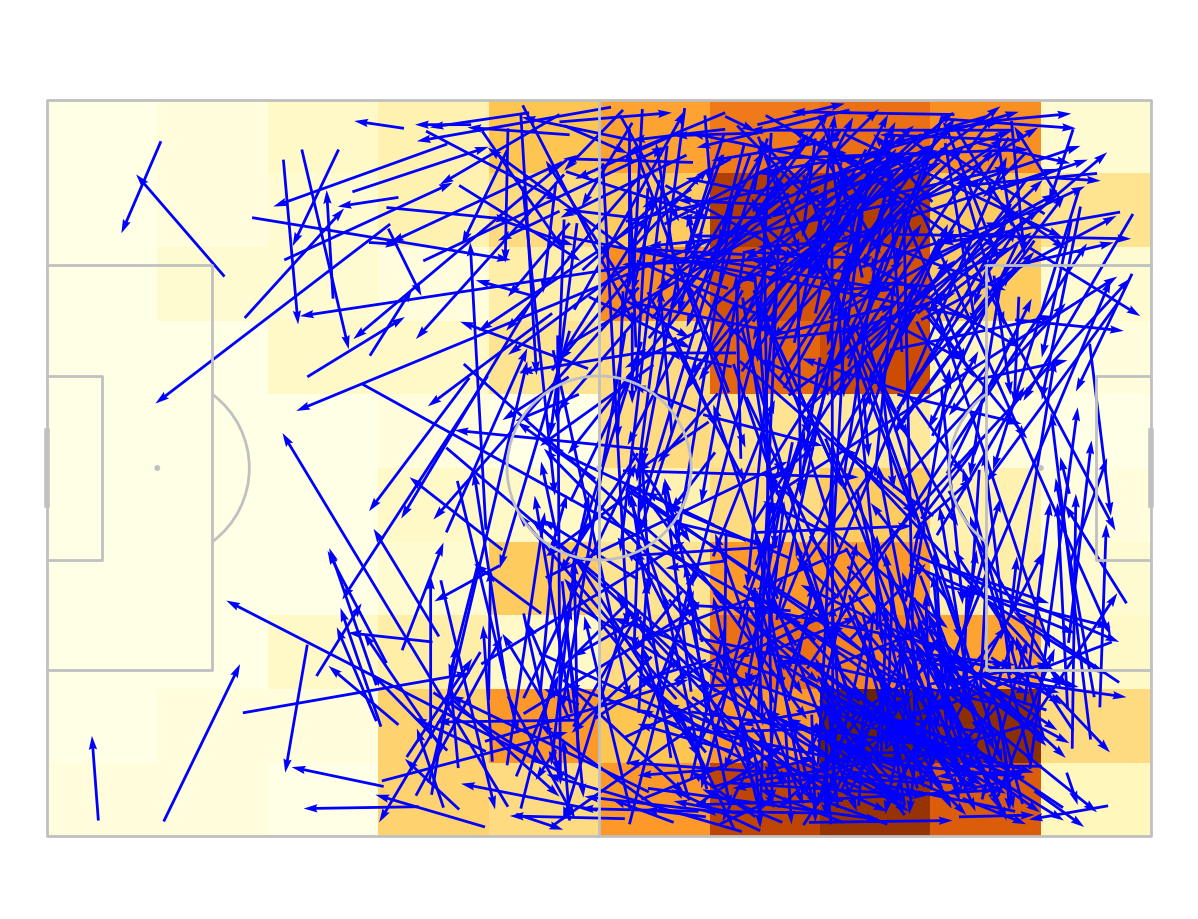

In [74]:
games_played = len(kdb_passes.match_id.unique())

pitch = Pitch(line_zorder=2,line_color='silver')
fig,ax = pitch.grid(grid_height=0.9,title_height=0.06,axis=False,endnote_height=0.04,
                   title_space=0,endnote_space=0)

bin_statistic = pitch.bin_statistic(kdb_passes.x,kdb_passes.y,statistic='count',bins=(10,10),normalize=False)
bin_statistic['statistic'] = (bin_statistic['statistic']/games_played)*90

pcm = pitch.heatmap(bin_statistic,cmap='YlOrBr',ax=ax['pitch'])
pitch.arrows(kdb_passes.x,kdb_passes.y,kdb_passes.end_x,kdb_passes.end_y,ax=ax['pitch'],color='blue',width=2)
plt.show()

In [71]:
city[['match_id','x','y','end_x','end_y','player_name','type_name','sub_type_name','outcome_name']]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,match_id,x,y,end_x,end_y,player_name,type_name,sub_type_name,outcome_name
0,3754258,NaN,NaN,NaN,NaN,NaN,Starting XI,NaN,NaN
1,3754258,NaN,NaN,NaN,NaN,NaN,Starting XI,NaN,NaN
2,3754258,NaN,NaN,NaN,NaN,NaN,Half Start,NaN,NaN
3,3754258,NaN,NaN,NaN,NaN,NaN,Half Start,NaN,NaN
4,3754258,89.3,74.8,NaN,NaN,Jesús Navas González,Ball Receipt,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3667,3754258,75.2,8.0,74.8,21.8,Rudy Gestede,Carry,NaN,NaN
3668,3754258,74.8,21.8,69.0,30.5,Rudy Gestede,Pass,NaN,NaN
3669,3754258,NaN,NaN,NaN,NaN,NaN,Half End,NaN,NaN
3670,3754258,NaN,NaN,NaN,NaN,NaN,Half End,NaN,NaN


In [75]:
kdb_passes['dx'] = kdb_passes['end_x'] - kdb_passes['x']
kdb_passes['dy'] = kdb_passes['end_y'] - kdb_passes['y']
avg_vectors = kdb_passes.groupby('player_name')[['dx', 'dy']].mean().reset_index()

avg_vectors

,player_name,dx,dy
0,Kevin De Bruyne,1.506407,0.180025
